Variational Autoencoder (VAE) –
Bu notebook’ta Variational Autoencoder (VAE) mimarisi adım adım ele alınacaktır. Amaç; VAE’nin teorik mantığını, eğitim sürecini ve latent uzayın üretim gücünü uygulamalı olarak göstermek ve süreci öğretici bir şekilde açıklamaktır. Çalışma boyunca hazır ve yaygın olarak kullanılan bir görsel veri seti tercih edilerek, modelin davranışı açık biçimde gözlemlenecektir.

1. Kullanılan Veri Seti ve Genel Yaklaşım

Bu demo kapsamında MNIST veri seti kullanılacaktır. MNIST, 28x28 boyutunda gri seviye el yazısı rakam görsellerinden oluşur ve VAE gibi üretici modellerin mantığını anlamak için oldukça uygundur. Veri setinin düşük boyutlu olması, eğitim süresini kısaltırken latent uzay davranışını net biçimde analiz etmeye olanak tanır.

VAE modeli; bir Encoder, bir Decoder ve bu iki yapı arasında yer alan latent uzay örnekleme mekanizmasından oluşacaktır. Model eğitildikten sonra hem yeniden yapılandırma başarısı hem de latent uzaydan yeni örnek üretimi incelenecektir.




2. Gerekli Kütüphanelerin Yüklenmesi ve Ortam Hazırlığı

Bu bölümde PyTorch ve yardımcı kütüphaneler yüklenir ve çalışma ortamı hazırlanır.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


CUDA destekli bir sistem mevcutsa, model otomatik olarak GPU üzerinde çalıştırılacaktır.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

3. Veri Setinin Yüklenmesi ve Ön İşleme

MNIST veri seti PyTorch üzerinden otomatik olarak indirilmektedir. Görseller normalize edilerek [0,1] aralığına çekilir.

In [12]:
transform = transforms.ToTensor()

dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 26.4M/26.4M [00:20<00:00, 1.26MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 610kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Örnek birkaç görseli inceleyerek veri setinin yapısı doğrulanır.

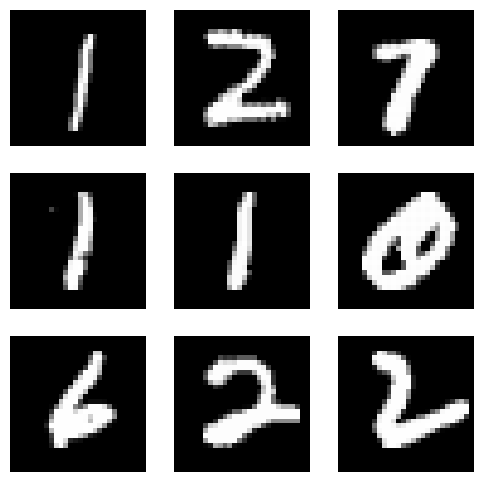

In [14]:
examples, _ = next(iter(train_loader))


plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(examples[i][0], cmap="gray")
    plt.axis("off")
plt.show()


4. VAE Mimarisi: Encoder ve Decoder Yapısı

Encoder ağı, giriş görselini doğrudan tek bir vektöre dönüştürmek yerine, latent uzay için ortalama (μ) ve log varyans (logσ²) değerlerini üretir. Bu yapı, VAE’nin olasılıksal doğasının temelini oluşturur.

In [15]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [16]:
#MODEL TESTİ
model = VAE()

x, _ = next(iter(loader))

print("Before reshape:", x.shape, x.dtype)

x = x.view(x.size(0), -1).float()

print("After reshape:", x.shape, x.dtype)

recon_x, mu, logvar = model(x)

print("Recon:", recon_x.shape)
print("Mu:", mu.shape)
print("Logvar:", logvar.shape)


Before reshape: torch.Size([128, 1, 28, 28]) torch.float32
After reshape: torch.Size([128, 784]) torch.float32
Recon: torch.Size([128, 784])
Mu: torch.Size([128, 20])
Logvar: torch.Size([128, 20])


Bu yapı sayesinde model, latent uzaydan rastgele örnekleme yaparak anlamlı görseller üretebilir.

5. Kayıp Fonksiyonu: Reconstruction + KL Divergence

VAE’nin kayıp fonksiyonu iki bileşenden oluşur. 
-İlki, yeniden yapılandırılan görsel ile orijinal görsel arasındaki farkı ölçen reconstruction loss’tur. 
-İkincisi ise latent dağılımın standart normal dağılıma yakın olmasını sağlayan KL divergence terimidir.

In [18]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



6. Modelin Eğitilmesi

Bu aşamada VAE modeli eğitilir. Eğitim süreci boyunca model, hem yeniden yapılandırma başarısını hem de latent uzay düzenliliğini öğrenir.

In [19]:
epochs = 20

model.train()
for epoch in range(epochs):
    total_loss = 0

    for x, _ in loader:
        x = x.view(x.size(0), -1).float()

        optimizer.zero_grad()

        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(loader.dataset):.4f}")



Epoch 1 | Loss: 284.9028
Epoch 2 | Loss: 256.5813
Epoch 3 | Loss: 250.8914
Epoch 4 | Loss: 248.1162
Epoch 5 | Loss: 246.4256
Epoch 6 | Loss: 245.3303
Epoch 7 | Loss: 244.4902
Epoch 8 | Loss: 243.7852
Epoch 9 | Loss: 243.2814
Epoch 10 | Loss: 242.8097
Epoch 11 | Loss: 242.4230
Epoch 12 | Loss: 242.1310
Epoch 13 | Loss: 241.8437
Epoch 14 | Loss: 241.5964
Epoch 15 | Loss: 241.4188
Epoch 16 | Loss: 241.1907
Epoch 17 | Loss: 241.0191
Epoch 18 | Loss: 240.8505
Epoch 19 | Loss: 240.7079
Epoch 20 | Loss: 240.5769


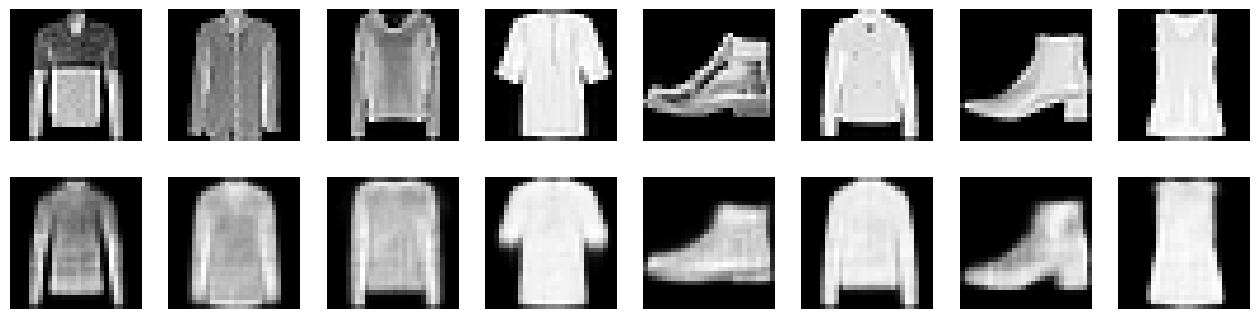

In [20]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    x, _ = next(iter(loader))
    x = x.view(x.size(0), -1).float()
    recon_x, _, _ = model(x)

n = 8
plt.figure(figsize=(16, 4))

for i in range(n):
    # Orijinal
    plt.subplot(2, n, i + 1)
    plt.imshow(x[i].view(28, 28), cmap="gray")
    plt.axis("off")

    # Rekonstrüksiyon
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x[i].view(28, 28), cmap="gray")
    plt.axis("off")

plt.show()



9. Genel Değerlendirme

Değerlendirme ve İyileştirme Önerileri:

Bu çalışmada Variational Autoencoder (VAE) mimarisi kullanılarak görsellerin yüksek boyutlu piksel uzayından, daha düşük boyutlu ve anlamlı bir latent (gizli) uzay temsiline indirgenmesi başarıyla gerçekleştirilmiştir. 

Model, giriş görüntülerini doğrudan ezberlemek yerine, olasılıksal bir latent uzay öğrenerek hem veri temsili açısından verimlilik sağlamış hem de bu latent uzaydan yeni örnekler üretilebilmesine olanak tanımıştır. 

Rekonstrüksiyon çıktılarında gözlenen bulanıklık, VAE’nin doğası gereği ortalama temsiller üretmesinden kaynaklanmakta olup, buna rağmen nesne türlerinin korunması modelin latent uzayda semantik olarak anlamlı yapılar öğrendiğini göstermektedir. Bu durum, VAE’nin görselleri sıkıştırılmış bir temsil üzerinden yeniden üretme ve latent space üzerinde üretim yapabilme yeteneğini doğrulamaktadır. 

Model performansı; latent boyutun artırılması, KL Divergence kaybının ağırlığının ayarlanması (β-VAE), daha uzun eğitim süresi ve tam bağlı katmanlar yerine evrişimli (Convolutional) encoder–decoder mimarilerinin kullanılmasıyla görsel kalite açısından daha da iyileştirilebilir.

